<a href="https://colab.research.google.com/github/JSJeong-me/ResNet/blob/main/5team_3class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train a Custom Resnet34 for Image Classification in fastai and PyTorch
Can I computer tell the diffence between a daisy and a dandelion? The answer is yes


This tutorial shows you how to train a state of the art image classification model with Resnet, in PyTorch, using the fastai library.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train Resnet34 image classification model](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train Resnet to recognize your custom classes. We use a [public flowers classification dataset](
https://public.roboflow.com/classification/flowers_classification), which is open source and free to use. You can also use this notebook on your own data.

To train our custom classifier we take the following steps:

* Install fastai dependencies
* Expand our training set via augmentations in Roboflow
* Download custom classificatio data from Roboflow
* Download pretrained Resnet Models
* Run frozen Resent training in fastai
* Find a favorable learning rate
* Run unfrozen training
* Inspect our model's evaluation metrics 
* Run Resnet inference on test images
* Export saved Resnet weights for future inference






# Install fastai dependencies

In [ ]:
!unzip ./5team.v1i.folder.zip

In [ ]:
!pip install fastai

In [3]:
from fastai.vision import *

# Downlaod Custom Classification Data From Roboflow

In [4]:
#build fastai dataset loader
np.random.seed(42)
#fastai automatically factors the ./train and ./valid folders into seperate datasets
#more details https://docs.fast.ai/vision.data.html#ImageDataLoaders.from_folder
path = Path('/content/')
data = ImageDataBunch.from_folder(path, size=224, num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
#double check the data classes
data.classes

['alpaca', 'polar_bears']

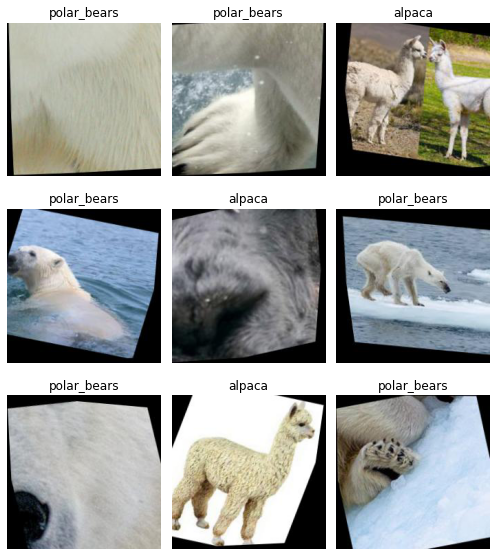

In [6]:
#take a peak at the batch to make sure things were loaded correctly
data.show_batch(rows=3, figsize=(7, 8))


# Set up fastai Resnet model

In [ ]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [ ]:
#print network layers
learn

# Train Custom Resnet Image Classifier

In [8]:
from fastai.callbacks import *
early_stop = EarlyStoppingCallback(learn, patience=20)
save_best_model = SaveModelCallback(learn, name='best_resnet34')

In [ ]:
#frozen training step
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(1, callbacks=[early_stop, save_best_model])

In [ ]:
#load best model from frozen training
learn.load('best_resnet34')


In [11]:
learn.unfreeze()

In [12]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)
    
    
    #loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #return the learning rate that produces the minimum loss divide by 10   
    return lrs[min_loss_index] / 10

In [13]:
optimal_lr = find_appropriate_lr(learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [14]:
learn.fit_one_cycle(50, max_lr=slice(optimal_lr/10, optimal_lr), callbacks=[early_stop, save_best_model])


epoch,train_loss,valid_loss,error_rate,time
0,0.137745,0.003176,0.000000,00:02
1,0.081806,0.001908,0.000000,00:02
2,0.072163,0.002880,0.000000,00:02
3,0.057142,0.002706,0.000000,00:02
4,0.044445,0.004767,0.000000,00:02
5,0.035461,0.011099,0.000000,00:02
6,0.031371,0.025553,0.031250,00:02
7,0.026270,0.051883,0.031250,00:02
8,0.023100,0.061358,0.031250,00:02
9,0.019618,0.051829,0.031250,00:02


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Better model found at epoch 0 with valid_loss value: 0.0031756556127220392.
Better model found at epoch 1 with valid_loss value: 0.0019083061488345265.
Epoch 22: early stopping


In [ ]:
learn.load('best_resnet34')


# Evaluate Classifier Performance

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


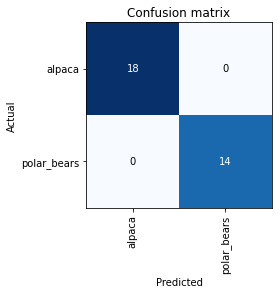

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


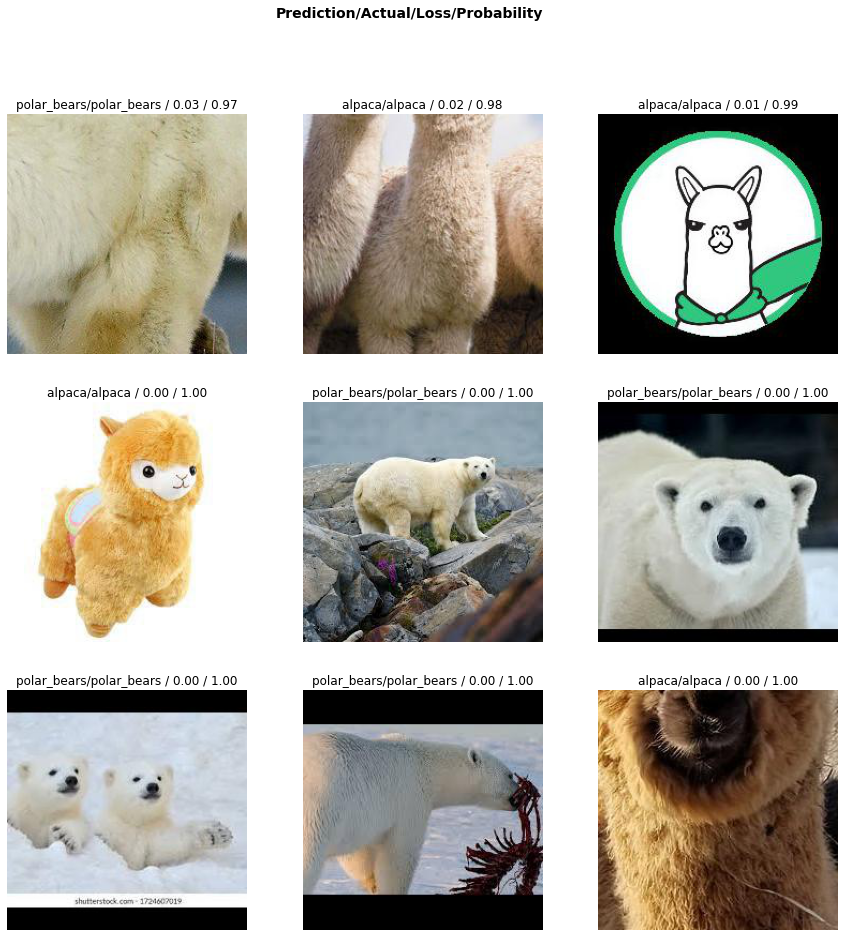

In [17]:
interp.plot_top_losses(9, figsize=(15,15))


/content/test/alpaca/d218cb848f_jpg.rf.8f64bb4d4d093bc3b62f3edf6fbe6e6d.jpg
alpaca


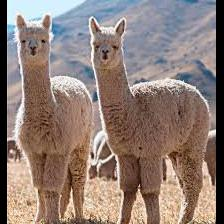



/content/test/alpaca/3686c29ddf_jpg.rf.de4bb6a0c4c4ecefa5d16ead97a92da0.jpg
alpaca


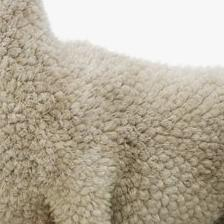



/content/test/alpaca/7ac3e2aa02_jpg.rf.abf8265b6734b078208fb29cf3945520.jpg
alpaca


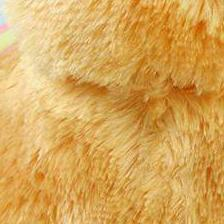



/content/test/alpaca/d5ef886f60_jpg.rf.9e1fef24784bf299498fd200ee1b50b3.jpg
alpaca


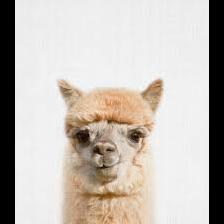



/content/test/polar_bears/5e0fdd8944_jpg.rf.0d3a7d38e400e6c426e5f928bbacc969.jpg
polar_bears


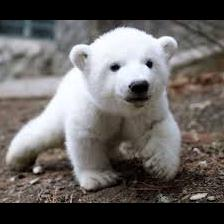



/content/test/polar_bears/594eb534ab_jpg.rf.8ba77dfabbf77a3f2c4894d647b6524f.jpg
polar_bears


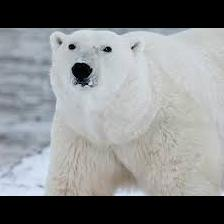



/content/test/polar_bears/ebf117ad73_jpg.rf.5b2e446822c5978f473a2bcd712d415b.jpg
polar_bears


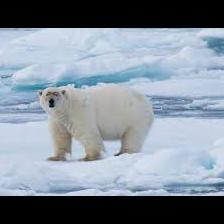



/content/test/polar_bears/e45a10c4d5_jpg.rf.7c181453b511b93412ab96bdbef6aea5.jpg
polar_bears


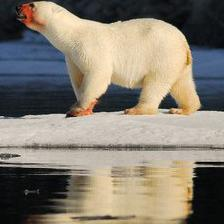



/content/test/polar_bears/4b8ed113dd_jpg.rf.ed5fe57fcf587f670a91d00aac5104b8.jpg
polar_bears


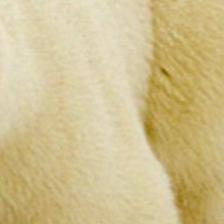



/content/test/polar_bears/c0bf7afc9b_jpg.rf.2e69ec60dc7a0d167a2eb99288885247.jpg
polar_bears


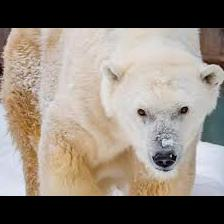



/content/test/polar_bears/c26bf1edb8_jpg.rf.5ddf57bbd293bcec1ab55d15a41403d8.jpg
polar_bears


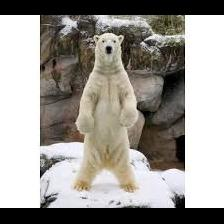



/content/test/polar_bears/4fda30f490_jpg.rf.900bf0378cdf29f94b03c75bce72eac0.jpg
polar_bears


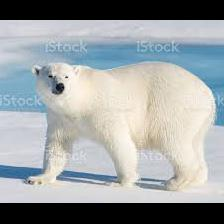



/content/test/polar_bears/58265151ff_jpg.rf.6f9dc873abb8ba492937e7b1fd89863f.jpg
polar_bears


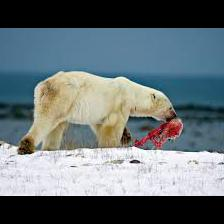



/content/test/polar_bears/4792e01e32_jpg.rf.fd1fccccad96031e36f359090c33c8bf.jpg
polar_bears


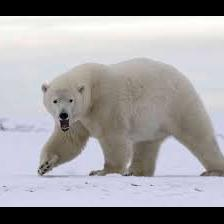



/content/test/polar_bears/1b9ac6fe11_jpg.rf.316e1307a5f84c6863be7b4e2dc00f86.jpg
polar_bears


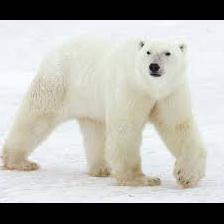



/content/test/polar_bears/2e4b7a45e6_jpg.rf.3499578e4734cdca45f60c7b4fab5d6a.jpg
polar_bears


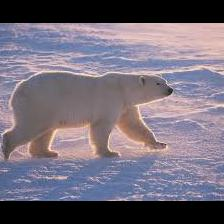

In [18]:
#run inference on test images
import glob
from IPython.display import Image, display

model = learn.model
model = model.cuda()
for imageName in glob.glob('/content/test/*/*.jpg'):
    print(imageName)
    img = open_image(imageName)
    prediction = learn.predict(img)
    #print(prediction)
    print(prediction[0])
    display(Image(filename=imageName))
    print("\n")

# Save custom classification model for future use

In [ ]:
#model is automatically saved with the "save_best_model" callback
%ls models/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
files.download('./models/best_resnet34.pth')